# Noise Gradcam

## 1. Import Necessary Libraries

In [1]:
import tensorflow as tf
from skimage.transform import resize
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display
import cv2
from tensorflow.keras.models import Model
from skimage.util import random_noise
!pip install ipywidgets
from ipywidgets import interact


## 2. Loading + Preprocessing MNIST DATA

In [2]:
(train_X, train_y), (test_X, test_y)= tf.keras.datasets.mnist.load_data()

In [3]:
def transform(data):
    nd=[]
    for i in data:
        i = cv2.cvtColor(i,cv2.COLOR_GRAY2RGB).astype('float64')
        i=cv2.resize(i,(64,64))
        #i/=255.
        nd.append(i)
    return np.array(nd)

In [4]:
train_X= transform(train_X)
test_X= transform(test_X)

In [5]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_y.reshape(-1,1))
train_y=enc.transform(train_y.reshape(-1,1)).toarray()
test_y=enc.transform(test_y.reshape(-1,1)).toarray()
cats=enc.categories_

## 3. VGG Model Training

In [6]:
model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(64,64,3),   
)

In [7]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [8]:
gm = tf.keras.layers.GlobalMaxPooling2D()(model.output)
dense1 =tf.keras.layers.Dense(512,activation='relu')(gm)
dense2 =tf.keras.layers.Dense(256,activation='relu')(dense1)
dense3 =tf.keras.layers.Dense(128,activation='relu')(dense2)
dense4 =tf.keras.layers.Dense(64,activation='relu')(dense3)
output =tf.keras.layers.Dense(10,activation='softmax')(dense4)
mnist_model = tf.keras.models.Model(inputs = model.input , outputs = output)
mnist_model.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
history= mnist_model.fit(x=train_X, y=train_y, validation_data=(test_X,test_y),epochs=5,batch_size=512)

Epoch 1/5
118/118 [==============================] - 46s 288ms/step - loss: 2.5185 - accuracy: 0.1940 - val_loss: 1.3781 - val_accuracy: 0.5104
Epoch 2/5
118/118 [==============================] - 33s 279ms/step - loss: 0.4691 - accuracy: 0.8475 - val_loss: 0.0940 - val_accuracy: 0.9720
Epoch 3/5
118/118 [==============================] - 34s 285ms/step - loss: 0.0928 - accuracy: 0.9724 - val_loss: 0.0891 - val_accuracy: 0.9762
Epoch 4/5
118/118 [==============================] - 34s 286ms/step - loss: 0.0623 - accuracy: 0.9818 - val_loss: 0.0525 - val_accuracy: 0.9852
Epoch 5/5
118/118 [==============================] - 34s 285ms/step - loss: 0.0474 - accuracy: 0.9858 - val_loss: 0.0421 - val_accuracy: 0.9879


## 4. Initializing Gradcam Functions

In [10]:
def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [11]:
def fuse_layers(layers, model, img, emphasize=False):
  '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap
    and superimposes the heatmap onto an image.

    Args:
      layers: list of strings
      model: tf model
      img: (img_width x img_height x 3) numpy array


    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.1, emphasize=emphasize)
  #cv2.imwrite('grad_new_vgg/'+count+'.jpg')
  return superimposed,cams

In [12]:
conv2D_layers = [layer.name for layer in reversed(mnist_model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(mnist_model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(mnist_model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]


In [13]:
import skimage as sk # load skimage libraries
from skimage import io
import matplotlib.pylab as plt
images = []

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
for kclass in range(0,10):
    ind = np.argwhere(np.argmax(test_y,axis=1)==kclass)
    images.append(test_X[ind[1][0]])
images=np.array(images)

In [14]:
def plot_images(images):
    fig = plt.figure(figsize=(18, 8))

    k=0
    for i in range(2):
        for j in range(5):
            ax = fig.add_subplot(2, 5, k+1)
            ax.imshow(images[k]) 
            ax.set_title('img1:'+ str(k))
            k+=1

    ax.axis('off')
    plt.show()

In [15]:
def plot_grad(images,flag,start=-4,):
    count=0
    fig = plt.figure(figsize=(18, 8))
    for i,image in enumerate(images):
        p = mnist_model.predict(np.expand_dims(image,axis=0))
        p=np.argmax(p)
        sp,cams=fuse_layers(conv2D_layers,mnist_model,cv2.cvtColor(image.astype('float32'), cv2.COLOR_RGB2BGR))
        ax = fig.add_subplot(2, 5,i+1)
        if flag==0:
            ax.imshow(sp)
        else:
            ax.imshow(np.mean(cams[start:],axis=0),cmap='jet')
        ax.set_title([label_names[kclass], 'class = {} , pclass= {}'.format(count,p)])
        count+=1
        ax.axis('off')


## 5. Analysis of MNIST on GradCam Using Noises

### 5.1 Normal MNIST GradCam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

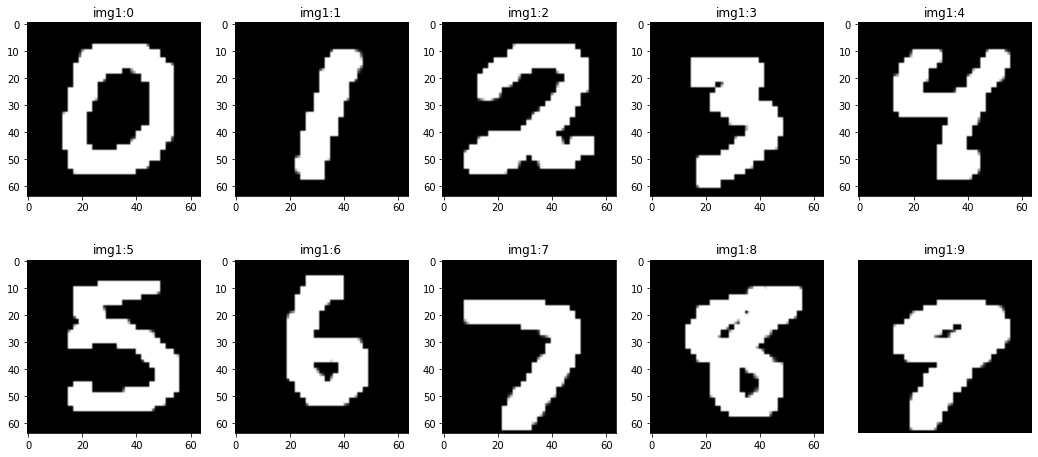

In [16]:
plot_images(images)

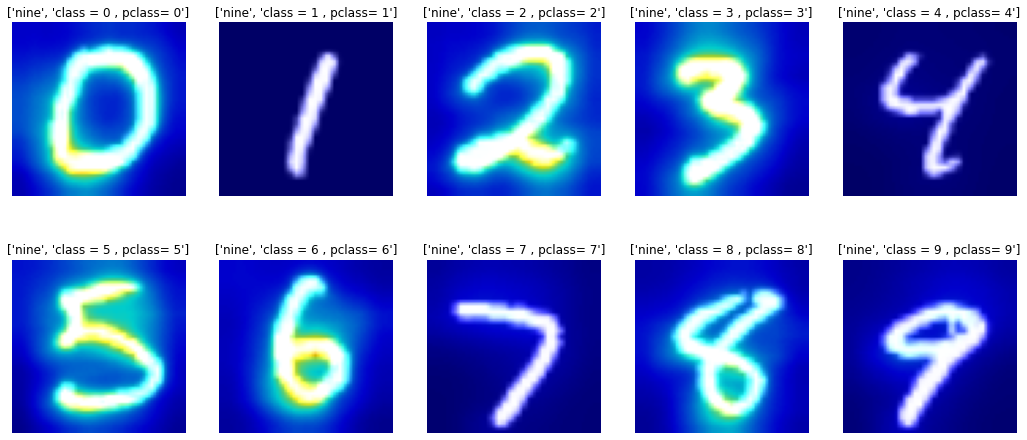

In [17]:
# GRADCAM OUTPUT OF ALL CONV LAYERS AVERAGES
plot_grad(images,flag=0)
plt.savefig('normal_vgg16_all.jpg')

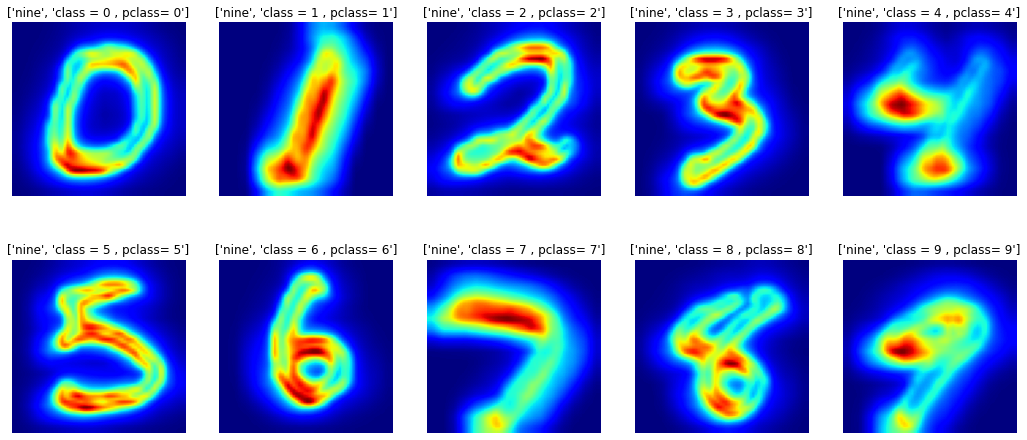

In [18]:
# GRADCAM OUTPUT OF LAST 6 CONV LAYERS AVERAGES
plot_grad(images,flag=1,start=-6)
plt.savefig('normal_vgg16_l6.jpg')

### 5.2 MNIST Affected by Gausian Noise GradCam

In [30]:
# Addition of Gausian Noise 
gaus_images=[]
for i in range(10):
    img= cv2.cvtColor(images[i].astype('float32'),cv2.COLOR_RGB2GRAY)
    noise_img= random_noise(img, mode='gaussian',mean=0 , var =0)
    noise_img=  cv2.cvtColor(noise_img.astype('float32'),cv2.COLOR_GRAY2RGB)
    gaus_images.append(noise_img)

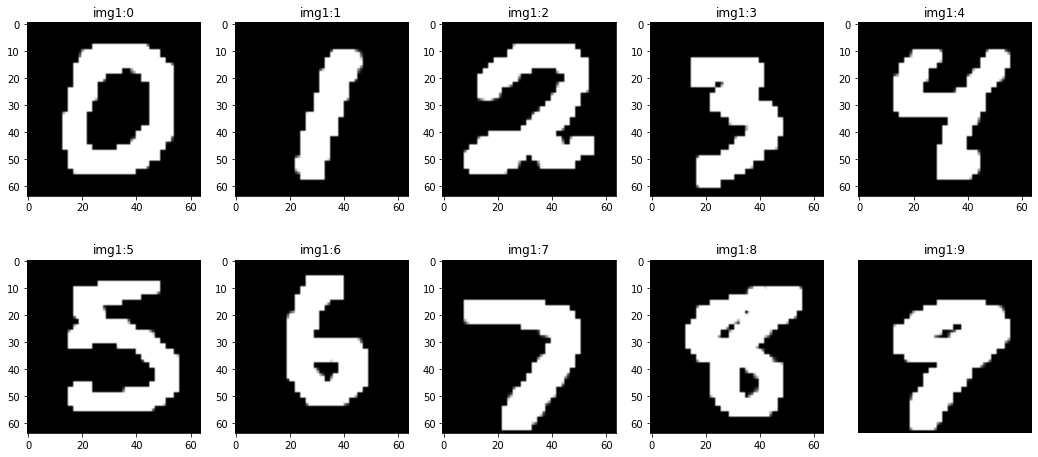

In [31]:
plot_images(gaus_images)

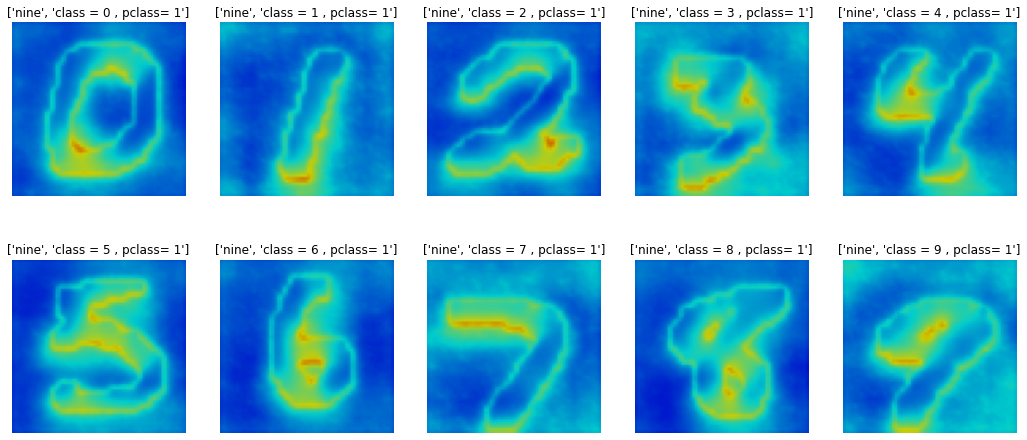

In [21]:
# GRADCAM OUTPUT OF ALL CONV LAYERS AVERAGES
plot_grad(gaus_images,flag=1,)
plt.savefig('gaus_vgg_avg_all.jpg')

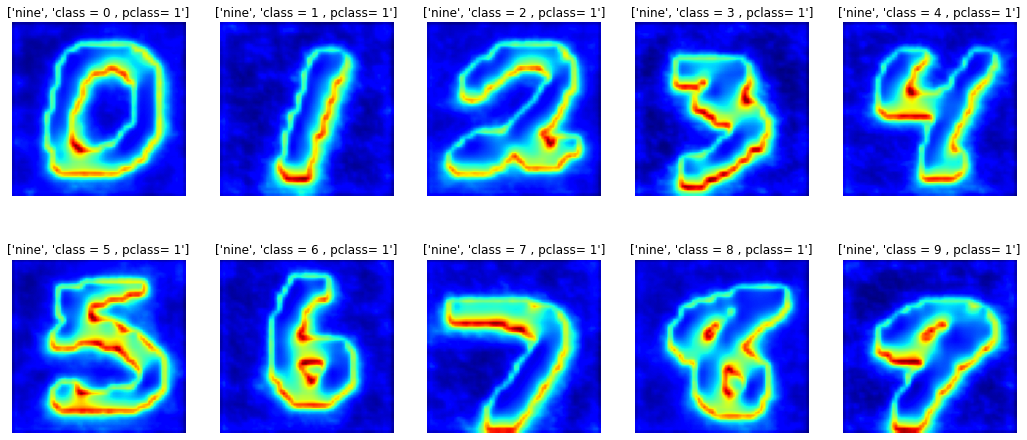

In [22]:
# GRADCAM OUTPUT OF LAST 6 CONV LAYERS AVERAGES
plot_grad(gaus_images,flag=1,start=-6)
plt.savefig('gaus_vgg_avg_l6.jpg')

### 5.3 MNIST Affected by Salt and Pepper Noise GradCam

In [23]:
# Addition of Salt and Pepper Noise 
sp_images=[]
for i in range(10):
    img= cv2.cvtColor(images[i].astype('float32'),cv2.COLOR_RGB2GRAY)
    noise_img= random_noise(img, mode='s&p',amount=0.1)
    noise_img=  cv2.cvtColor(noise_img,cv2.COLOR_GRAY2RGB)
    sp_images.append(noise_img)

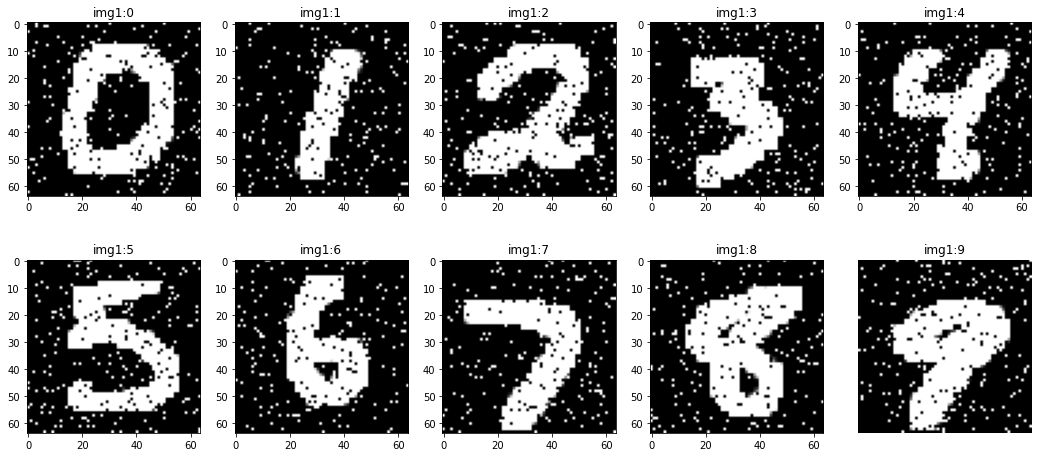

In [24]:
plot_images(sp_images)

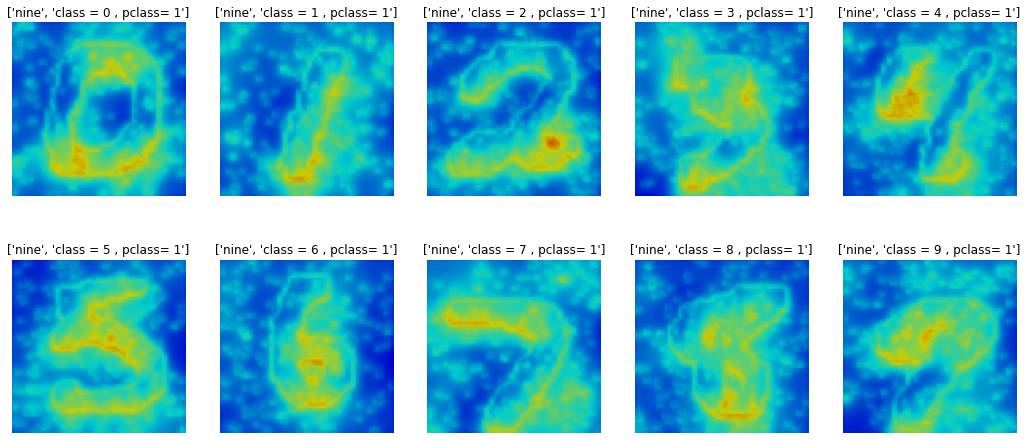

In [25]:
# GRADCAM OUTPUT OF ALL CONV LAYERS AVERAGES
plot_grad(sp_images,flag=0)
plt.savefig('salt_vgg16_all.jpg')

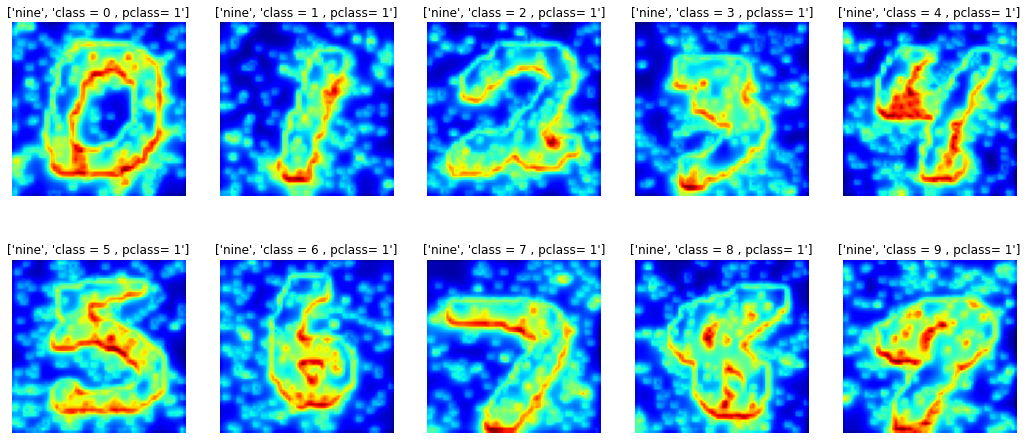

In [26]:
# GRADCAM OUTPUT OF LASt 6 CONV LAYERS AVERAGES
plot_grad(sp_images,flag=1,start=-6)
plt.savefig('salt_vgg16_l6.jpg')

## 6 Interactive 

In [32]:

@interact(mean=(0, 1,0.1),variance=(0,1,0.1))
def double_number(mean,variance):
    gaus_images=[]
    for i in range(10):
        img= cv2.cvtColor(images[i].astype('float32'),cv2.COLOR_RGB2GRAY)
        noise_img= random_noise(img, mode='gaussian',mean=mean,var=variance)
        noise_img=  cv2.cvtColor(noise_img.astype('float32'),cv2.COLOR_GRAY2RGB)
        gaus_images.append(noise_img)
    plot_grad(gaus_images,flag=1, start =-6)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='mean', max=1.0), FloatSlider(value=0.0, description=…

In [28]:
@interact(amount=(0, 1,0.1))
def double_number(amount):
    sp_images=[]
    for i in range(10):
        img= cv2.cvtColor(images[i].astype('float32'),cv2.COLOR_RGB2GRAY)
        noise_img= random_noise(img, mode='s&p',amount=amount)
        noise_img=  cv2.cvtColor(noise_img.astype('float32'),cv2.COLOR_GRAY2RGB)
        sp_images.append(noise_img)
    plot_grad(sp_images,flag=0)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='amount', max=1.0), Output()), _dom_classes=('widget-…